<a href="https://colab.research.google.com/github/kupaqu/superdarn-nn/blob/main/25feb_superdarn_nn_pwr0_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from datetime import datetime, timedelta
import random

In [ ]:
class DataLoader:
    def __init__(self,
                 datapath,
                 shuffle=True):
        self.shuffle = shuffle
        self.data = {}

        for root, _, files in os.walk(datapath):
            for name in files:
                filename = name.split('.')
                self.data[filename[0] + filename[1]] = np.load(os.path.join(root, name))

    def __call__(self):
        keys = list(self.data.keys())
        if self.shuffle:
            random.shuffle(keys)
        # итерация по ключам в словаре self.data
        for key in keys:
            # если маска целевого значения пустая, то пропускаем пример
            if np.all(self.data[key][:,:,-1,:,:] == 0.):
                continue
            seq = self.__getSequence(key)
            arrays = []
            badCount = 0
            # итерация по историческим данным
            for item in seq:
                # некоторые исторические данные могут отсутствовать
                try:
                    if np.all(self.data[item][:,:,-1,:,:] == 0.):
                        badCount += 1
                    arrays.append(self.data[item])
                except KeyError:
                    # print(f'No key: {item}')
                    badCount += 1
                    arrays.append(np.zeros_like(self.data[key]))
            # если пропусков в данных больше чем 10%, то пропускаем пример
            # print(f'Bad count: {badCount}')
            if badCount / len(arrays) > 0.1:
                continue
            else:
                x = np.concatenate(arrays, axis=1)
                y = self.data[key]
                # for beam in range(16):
                #     yield x[:,:,:,beam,0], y[:,:,:-1,beam,0]
                yield x[:,:,0:1,0,0], y[:,:,0:1,0,0]
    
    def __getSequence(self, key):
        keyDT = datetime.strptime(key, '%Y%m%d%H%M')
        # список массивов периодов за неделю до целевого массива
        weekBefore = []
        for i in range(24*7, 0, -2):
            hoursBefore = (keyDT-timedelta(hours=i)).strftime('%Y%m%d%H%M')
            weekBefore.append(hoursBefore)
        return weekBefore

In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
# генератор
def get_generator():

    history = tf.keras.layers.Input(shape=(70, 5040, 1))

    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(1, 7),
        dilation_rate=(1, 12*60),
        activation='relu'
    )(history)

    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(1, 12),
        dilation_rate=(1, 60),
        activation='relu'
    )(x)

    output = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=1,
        activation='linear'
    )(x)

    generator = tf.keras.models.Model(history, output, name='generator')

    return generator

# дискриминатор
def get_discriminator():

    history = tf.keras.layers.Input(shape=(70, 5040, 1))
    target = tf.keras.layers.Input(shape=(70, 60, 1))
    concat = tf.keras.layers.Concatenate(axis=2)([history, target])
    
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(1, 7),
        dilation_rate=(1, 12*60),
        activation='relu'
    )(concat)

    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(1, 13),
        dilation_rate=(1, 60),
        activation='relu'
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=(70, 1),
        activation='sigmoid'
    )(x)

    output = tf.keras.layers.Flatten()(x)
    
    discriminator = tf.keras.models.Model([history, target], output, name='discriminator')

    return discriminator

In [ ]:
class RadarGAN(keras.Model):
    def __init__(self, discriminator, generator):
        super(RadarGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.gen_mae_tracker = keras.metrics.Mean(name="generator_mae")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.gen_mae_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(RadarGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.mae = keras.losses.MeanAbsoluteError()

    def train_step(self, data):

        # класс 1 - настоящие данные, класс 0 - дискриминированные данные
        x, y = data
        x_shape = tf.shape(x)
        y_shape = tf.shape(y)

        # обучение дискриминатора
        for step in range(1):
            
            # маска по Бернулли
            p = tf.constant([0.8])
            r = tf.random.uniform(shape=x_shape, maxval=1)
            b = tf.math.greater(p, r)
            f = tf.cast(b, dtype=tf.dtypes.float64)

            # выход генератора
            generated = tf.cast(self.generator(tf.math.multiply(x, f)), dtype=tf.dtypes.float64)

            with tf.GradientTape() as tape:
                real = self.discriminator([x, y])
                fake = self.discriminator([x, generated])
                
                # значения потерь на чистых данных
                loss_on_real = self.loss_fn(tf.ones_like(real), real)
                loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
                
                # целевое значение дискриминатора
                real_mixed = tf.math.round(tf.random.uniform(shape=(y_shape[0], y_shape[2]), minval=0, maxval=1, dtype=tf.dtypes.float64))

                # маска для реальных данных
                real_mask_mixed = tf.reshape(real_mixed, shape=(y_shape[0], 1, y_shape[2], 1))
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[1], axis=1)
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[3], axis=3)
                # маска для фейковых данных
                fake_mask_mixed = tf.math.subtract(tf.ones(shape=tf.shape(real_mask_mixed), dtype=tf.dtypes.float64), real_mask_mixed)

                # перемешивание данных
                mixed = tf.math.add(tf.math.multiply(real_mask_mixed, y), tf.math.multiply(fake_mask_mixed, generated))

                predictions = self.discriminator([x, mixed])

                loss_on_mixed = self.loss_fn(real, predictions)

                d_loss = loss_on_real + loss_on_fake + loss_on_mixed

            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        
        # таргет генератора как выход дискриминатора
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)

        # тренировка генератора
        for step in range(1):
            with tf.GradientTape() as tape:

                # Бернулли
                p = tf.constant([0.8])
                r = tf.random.uniform(shape=x_shape, maxval=1)
                b = tf.math.greater(p, r)
                f = tf.cast(b, dtype=tf.dtypes.float64)

                generated = tf.cast(self.generator(tf.math.multiply(x, f)), dtype=tf.dtypes.float64)

                discriminated = self.discriminator([x, generated])
                g_loss = self.loss_fn(g_target, discriminated)
                g_mae = self.mae(y, generated)
                
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

    def test_step(self, data):
        # Unpack the data
        x, y = data
        y_shape = tf.shape(y)

        # Compute predictions
        generated = self.generator(x)
        real = self.discriminator([x, y], training=False)
        fake = self.discriminator([x, generated], training=False)

        # Compute losses
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)
        g_loss = self.loss_fn(g_target, fake)
        g_mae = self.mae(y, generated)

        loss_on_real = self.loss_fn(tf.ones_like(real), real)
        loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
        
        d_loss = loss_on_real + loss_on_fake

        # Update losses
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

In [ ]:
# если обучать с нуля
radar_gan = RadarGAN(discriminator=get_discriminator(), generator=get_generator())

# дообучение
# radar_gan = RadarGAN(discriminator=keras.models.load_model('drive/MyDrive/radargan_discriminator_new.hdf5'), generator=keras.models.load_model('drive/MyDrive/radargan_generator_new.hdf5'))

# графическое изображение структуры
tf.keras.utils.plot_model(radar_gan.generator, to_file='g.png', show_shapes=True)
tf.keras.utils.plot_model(radar_gan.discriminator, to_file='d.png', show_shapes=True)

radar_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy()
)

In [ ]:
radar_gan.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 70, 5040, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 70, 720, 64)       512       
                                                                 
 conv2d_4 (Conv2D)           (None, 70, 60, 64)        49216     
                                                                 
 conv2d_5 (Conv2D)           (None, 70, 60, 1)         65        
                                                                 
Total params: 49,793
Trainable params: 49,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
radar_gan.discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 5040, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 70, 60, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 70, 5100, 1)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                      

In [ ]:
batch_size = 4

train_loader = DataLoader('drive/MyDrive/2002-train')
val_loader = DataLoader('drive/MyDrive/2002-val')

train_dataset = tf.data.Dataset.from_generator(train_loader, output_types=(tf.float64, tf.float64)).batch(batch_size)
val_dataset = tf.data.Dataset.from_generator(val_loader, output_types=(tf.float64, tf.float64)).batch(batch_size)

In [ ]:
import matplotlib.pyplot as plt

def plot_output(gan, dataset, channel=0, n_examples=5):
    dataset = dataset.as_numpy_iterator()
    figure, axis = plt.subplots(4, n_examples)

    for i in range(n_examples):
        x, y = dataset.next()
        fake = radar_gan.generator.predict(x)
        d_real = radar_gan.discriminator.predict([x, y])
        d_fake = radar_gan.discriminator.predict([x, fake])

        axis[0, i].imshow(y[0, :, :, channel])
        axis[0, i].set_title("R")

        axis[1, i].imshow(fake[0, :, :, channel])
        axis[1, i].set_title("G")

        axis[2, i].imshow((y-fake)[0, :, :, channel])
        axis[2, i].set_title("R - G")

        axis[3, i].hist((y-fake)[0, :, :, channel])
        axis[2, i].set_title("R - G distr")

    plt.show()
    plt.hist

In [ ]:
hist = radar_gan.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100
44/44 [==============================] - 107s 2s/step - g_loss: 0.6924 - d_loss: 2.0997 - g_mae: 1.7503 - val_g_loss: 0.6844 - val_d_loss: 1.4710 - val_g_mae: 2.5269
Epoch 2/100
44/44 [==============================] - 85s 2s/step - g_loss: 0.6902 - d_loss: 2.0840 - g_mae: 4.5581 - val_g_loss: 0.9776 - val_d_loss: 0.9499 - val_g_mae: 2.7360
Epoch 3/100
44/44 [==============================] - 87s 2s/step - g_loss: 0.7952 - d_loss: 2.2052 - g_mae: 2.3492 - val_g_loss: 0.6921 - val_d_loss: 1.2230 - val_g_mae: 9.2512
Epoch 4/100
44/44 [==============================] - 88s 2s/step - g_loss: 0.8492 - d_loss: 1.5564 - g_mae: 6.6463 - val_g_loss: 0.7444 - val_d_loss: 1.4883 - val_g_mae: 1.2876
Epoch 5/100
44/44 [==============================] - 90s 2s/step - g_loss: 0.8102 - d_loss: 2.0009 - g_mae: 1.1925 - val_g_loss: 0.8268 - val_d_loss: 1.6005 - val_g_mae: 1.3757
Epoch 6/100
44/44 [==============================] - 89s 2s/step - g_loss: 0.7509 - d_loss: 2.2994 - g_mae: 2.7768

KeyboardInterrupt: ignored

In [ ]:
radar_gan.generator.save('drive/MyDrive/radargan_generator_new.hdf5')
radar_gan.discriminator.save('drive/MyDrive/radargan_discriminator_new.hdf5')

1/1 [==============================] - 0s 82ms/step


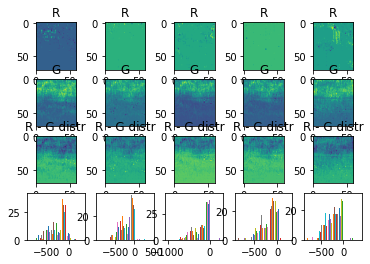

In [ ]:
plot_output(radar_gan, val_dataset)

In [ ]:
for x, y in val_dataset:
    fake = radar_gan.generator.predict(x)
    print('real: ', radar_gan.discriminator.predict([x, y]))
    print('fake: ', radar_gan.discriminator.predict([x, fake]))
    break

1/1 [==============================] - 0s 198ms/step
real:  [[0.12299392 0.14818461 0.15613697 0.14313833 0.14884038 0.14018059
  0.14627269 0.16531155 0.12647396 0.13885328 0.12312074 0.13546288
  0.1228569  0.13932237 0.10938223 0.13673139 0.13246202 0.12237357
  0.17072533 0.12404244 0.15393223 0.14283423 0.12610096 0.13094504
  0.11951814 0.15117694 0.12661663 0.122927   0.13018914 0.12357813
  0.12914734 0.14583942 0.14166886 0.12429303 0.10073702 0.12374946
  0.12372098 0.1364767  0.12669267 0.09791763 0.12850146 0.12414281
  0.13919446 0.13836011 0.12411433 0.13344015 0.1307629  0.1297187
  0.1352732  0.13398159 0.13294557 0.1381369  0.14191769 0.16560064
  0.13698557 0.16725518 0.14449807 0.13981925 0.15050986 0.16495003]
 [0.12373848 0.11226283 0.12609647 0.1088097  0.1403449  0.13307287
  0.14093816 0.13249156 0.11588082 0.12240462 0.11511814 0.11540442
  0.12808193 0.13356431 0.13364919 0.137707   0.10615809 0.11067825
  0.17259336 0.12653756 0.10836173 0.11595498 0.11239017

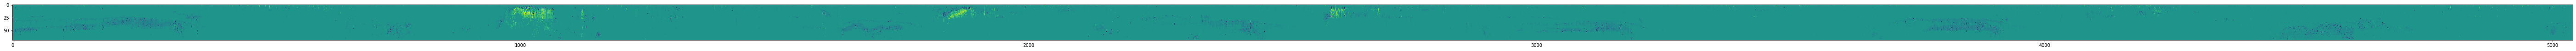

In [ ]:
for x, y in train_dataset:
    plt.figure(figsize=(100, 100))
    plt.imshow(x[0,:,:,0])
    break

In [ ]:
plt.plot(hist.history['g_mae'])
plt.plot(hist.history['val_g_mae'])
plt.title('generator MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
plt.plot(hist.history['g_loss'])
plt.plot(hist.history['d_loss'])
plt.title('g and d training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()

In [ ]:
plt.plot(hist.history['val_g_loss'])
plt.plot(hist.history['val_d_loss'])
plt.title('g and d validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()